In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler

In [2]:
""" 
This function prints out a confusion matrix specifically for this task. The labels are defined inside the function for that reason.
It will print the confusion matrix values as percentages by default and raw counts if the data is specified otherwise.

"""
def print_ConfusionMatrix(cm:confusion_matrix, title:str, normalized:bool):
    labels = ["Looking for job", "Not looking for job"]

    plt.figure(figsize=(6, 5))
    if(normalized == True):
        fmt = ".2%"
    else:
        fmt = "d"
    sns.heatmap(cm, annot=True, fmt = fmt, cmap='coolwarm',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [3]:
train_data = pd.read_csv("aug_train.csv", delimiter = ",")
test_data = pd.read_csv("aug_test.csv", delimiter = ",")

In [4]:
test_data

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [5]:
print(train_data["company_type"])

0                   NaN
1               Pvt Ltd
2                   NaN
3               Pvt Ltd
4        Funded Startup
              ...      
19153               NaN
19154               NaN
19155           Pvt Ltd
19156           Pvt Ltd
19157               NaN
Name: company_type, Length: 19158, dtype: object


Important to note: 32% of the company type responses are missing values. Why might this be? Maybe some people don't know what kind of company they work for (which is crazy), maybe others have NDAs so they can't specify. Regardless that's too much data to ignore so dummy_na is True for get_dummies.

Additionally, 31% of the responses for company size are missing, likely for similar reasons as company type.

24% of respondents didn't select anything for the gender question, pretty sure they know their own gender though. 

In [6]:
(train_data["target"] == False).sum()

14381

In [7]:
#Define style to use for visualizations
plt.style.use("petroff10")

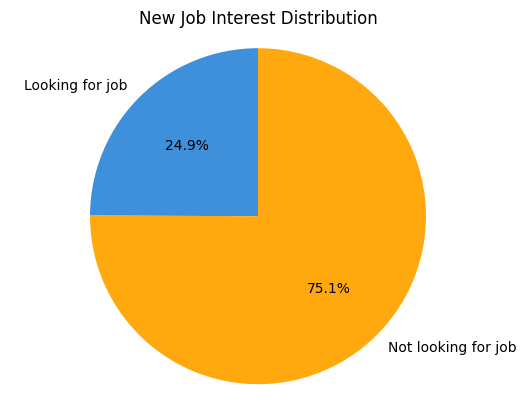

<Figure size 1920x1440 with 0 Axes>

In [8]:
labels = ["Looking for job", "Not looking for job"]
Job_Change = train_data["target"].sum()
No_Job_Change = (train_data["target"] == False).sum()

counts = [Job_Change, No_Job_Change]

plt.pie(counts, labels=labels, autopct='%.1f%%', startangle=90)
plt.title("New Job Interest Distribution")
plt.axis('equal')  # Equal aspect ratio makes the pie circular
plt.figure(dpi = 300)
plt.show()

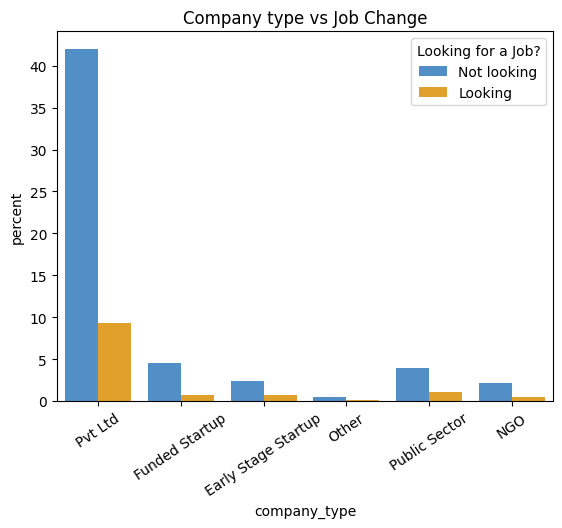

<Figure size 1920x1440 with 0 Axes>

In [9]:
sns.countplot(x='company_type', hue='target', stat= "percent" ,data=train_data)
plt.title("Company type vs Job Change")
plt.legend(title = "Looking for a Job?", labels = ["Not looking","Looking"] )
plt.xticks(rotation=34)
plt.figure(dpi = 300)
plt.show()

<Figure size 1920x1440 with 0 Axes>

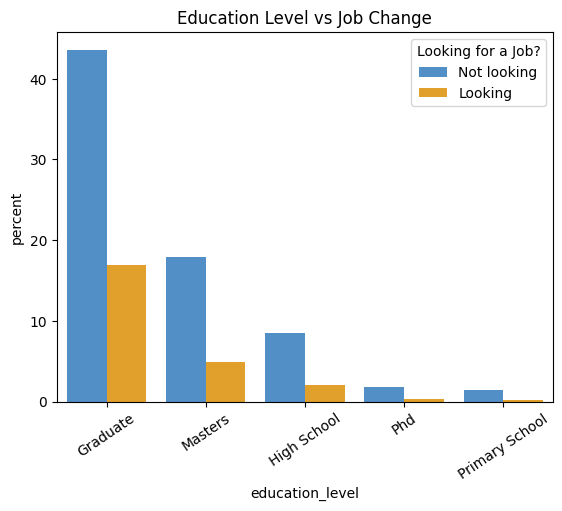

<Figure size 1920x1440 with 0 Axes>

In [10]:
sns.countplot(x='education_level', hue='target', stat="percent", data=train_data)
plt.title("Education Level vs Job Change")
plt.legend(title = "Looking for a Job?", labels = ["Not looking","Looking"] )
plt.xticks(rotation=34)
plt.figure(dpi = 300)

<Axes: xlabel='training_hours', ylabel='Density'>

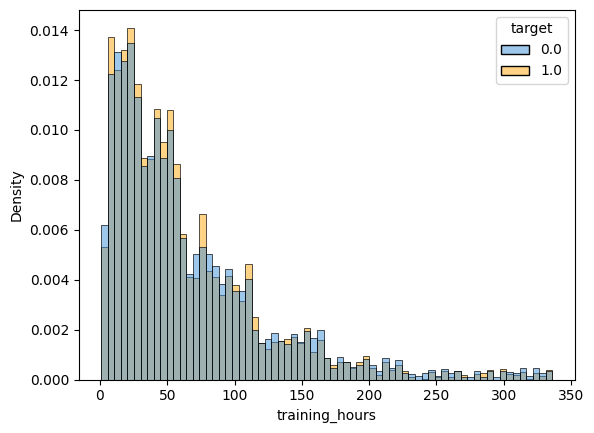

In [11]:
sns.histplot(data=train_data, x='training_hours', hue='target', stat='density', common_norm=False)

In [12]:
#City code is removed currently because it more than doubles the amount of columns in the dataset after get_dummies is called


#One-hot encode variables and drop irrelevant columns for analysis
train_dummies = pd.get_dummies(train_data, dummy_na= True)

labels = train_dummies["target"]
train_dummies.drop(["target","relevent_experience_nan","enrollee_id"], axis = 1,inplace = True)
x_train, x_test, y_train, y_test = train_test_split(train_dummies, labels, test_size = 0.2, random_state = 21)

In [13]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (15326, 195)
y_train shape: (15326,)
x_test shape: (3832, 195)
y_test shape: (3832,)


In [14]:
train_dummies

,city_development_index,training_hours,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_Public Sector,company_type_Pvt Ltd,company_type_nan,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,last_new_job_nan
0,0.920,36,False,False,False,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
1,0.776,47,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,0.624,83,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,0.789,52,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,0.767,8,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,42,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
19154,0.920,52,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
19155,0.920,44,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
19156,0.802,97,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [15]:
train_dummies.dtypes

city_development_index    float64
training_hours              int64
city_city_1                  bool
city_city_10                 bool
city_city_100                bool
                           ...   
last_new_job_3               bool
last_new_job_4               bool
last_new_job_>4              bool
last_new_job_never           bool
last_new_job_nan             bool
Length: 195, dtype: object

In [16]:
scaler = MinMaxScaler()

#normalize training, validation, test data
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [17]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight="balanced")

In [18]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [19]:
#Determining the accuracy of the model: How accurate is it in predicting people that would leave?
train_probs = rf_model.predict_proba(x_train)
train_probs = train_probs[:, 1]

threshold = 0.50
train_preds = (train_probs >= threshold).astype(y_train.dtype)

train_acc = np.mean(train_preds == y_train)
train_base_rate = np.mean(y_train)
train_rel_acc = np.abs((1 - train_base_rate) - train_acc) * 100

print(f"Model Accuracy: {train_acc:.2f}")
print(f"Model Relative Accuracy: {train_rel_acc:.2f}%")

Model Accuracy: 1.00
Model Relative Accuracy: 24.83%


In [20]:
train_results = (x_train.sum(axis=1) >= 6).astype(y_train.dtype)
train_cm = confusion_matrix(train_preds, y_train, normalize = "true")

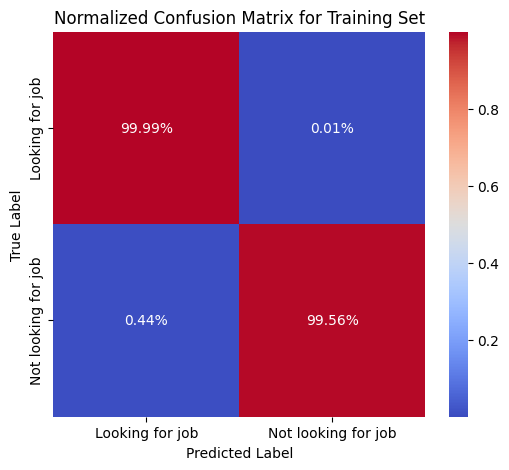

In [21]:
print_ConfusionMatrix(train_cm, "Normalized Confusion Matrix for Training Set", normalized = True)

In [22]:
val_probs = rf_model.predict_proba(x_test)
val_probs = val_probs[:, 1]

threshold = 0.70
val_preds = (val_probs >= threshold).astype(y_test.dtype)

val_acc = np.mean(val_preds == y_test)
val_base_rate = np.mean(y_test)
val_rel_acc = np.abs((1 - val_base_rate) - val_acc) * 100

print(f"Model Accuracy: {val_acc:.2f}")
print(f"Model Relative Accuracy: {val_rel_acc:.2f}%")

Model Accuracy: 0.77
Model Relative Accuracy: 1.62%


In [23]:
#validation_results = (x_test.sum(axis=1) >= 6).astype(y_test.dtype)
val_cm = confusion_matrix(val_preds, y_test, normalize = "true")

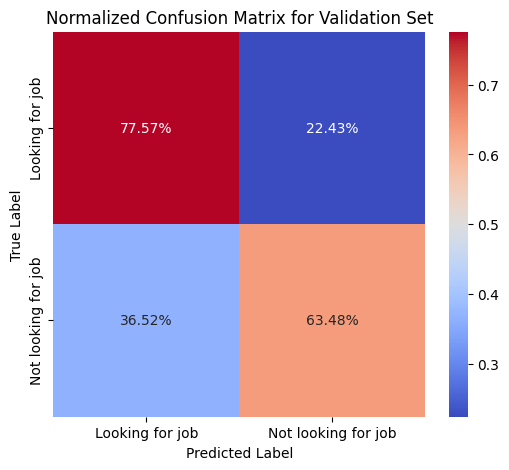

In [24]:
val_cm = confusion_matrix(val_preds, y_test, normalize = "true")
print_ConfusionMatrix(val_cm, "Normalized Confusion Matrix for Validation Set", normalized =True)

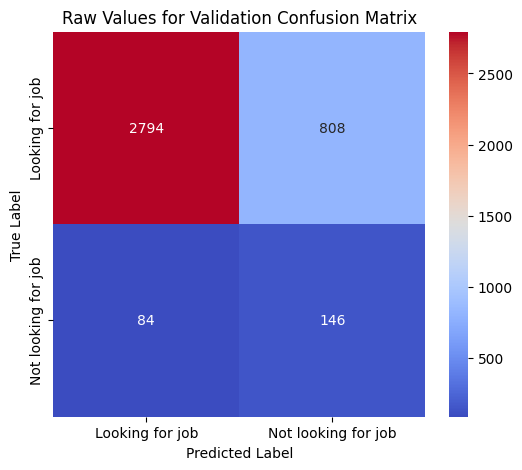

In [25]:
val_cm = confusion_matrix(val_preds, y_test)
print_ConfusionMatrix(val_cm, "Raw Values for Validation Confusion Matrix", normalized = False)

In [26]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      2878
         1.0       0.63      0.15      0.25       954

    accuracy                           0.77      3832
   macro avg       0.71      0.56      0.55      3832
weighted avg       0.74      0.77      0.71      3832



Accuracy: (2566+403)/(2566+551+312+403) = 2969/3832 = .7748. roughly 77% accuracy
Precision: 2566/(2566+312) = 2566/2878 = 0.8916
Recall: 2566/(2566+551) = 2566/3117 = 0.8232
F1-Score:2*((0.89*0.82) / (0.89+0.82)) = 2*(0.7298/1.71) = 2*0.42678 = 0.85

### Some Metrics Derived from the Confusion Matrix:
- **Accuracy**: The overall correctness of the model.
$$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Precision**: The proportion of positive predictions that are actually correct.
$$
  \text{Precision} = \frac{TP}{TP + FP}
$$

- **Recall (Sensitivity)**: The proportion of actual positives that are correctly identified.
$$
  \text{Recall} = \frac{TP}{TP + FN}
$$

- **F1-Score**: The harmonic mean of precision and recall.
$$
  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [27]:
feature_importances = rf_model.feature_importances_

In [28]:
Feature_Importances = pd.DataFrame({
    'Feature': train_dummies.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top20 = Feature_Importances.iloc[:20, ]

In [29]:
top20

,Feature,Importance
1,training_hours,0.140343
0,city_development_index,0.112345
66,city_city_21,0.053465
180,company_size_nan,0.039035
187,company_type_nan,0.030987
186,company_type_Pvt Ltd,0.019798
188,last_new_job_1,0.018125
136,education_level_Graduate,0.015471
7,city_city_103,0.014071
127,gender_Male,0.013753


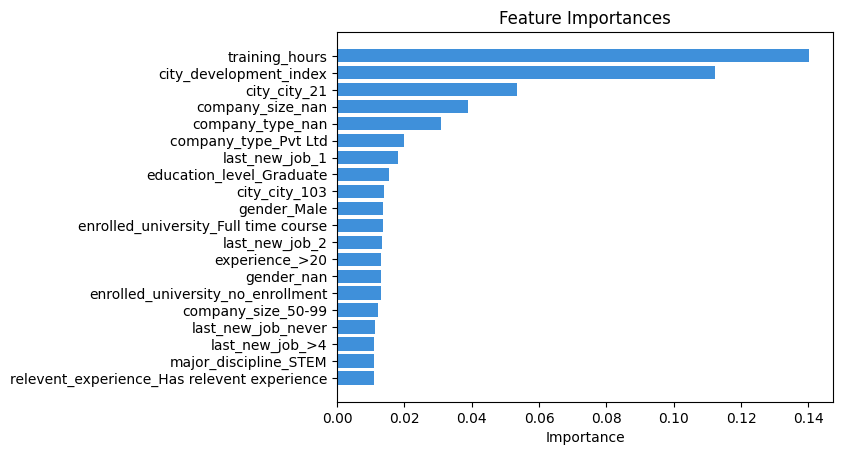

<Figure size 1920x1440 with 0 Axes>

In [30]:
plt.barh(top20["Feature"], top20["Importance"])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.figure(dpi = 300)
plt.show()

# Neural Network. Data has been normalized, not sure if there's more cleaning/preprocessing to do.

In [79]:
hr_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")])

In [80]:
hr_nn2 = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")])

In [70]:
hr_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","AUC"])
hr_nn2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","AUC"])

## Training set NN Compilation

In [71]:
history = hr_nn.fit(x=x_train, y=y_train, batch_size=32, epochs=50)
history2 = hr_nn2.fit(x=x_train, y=y_train, batch_size=32, epochs=50)

Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.6889 - accuracy: 0.7401 - loss: 0.5215
Epoch 2/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8079 - accuracy: 0.7923 - loss: 0.4413
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8105 - accuracy: 0.7946 - loss: 0.4348
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8154 - accuracy: 0.7981 - loss: 0.4303
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8288 - accuracy: 0.8056 - loss: 0.4172
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8408 - accuracy: 0.8150 - loss: 0.4055
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8478 - accuracy: 0.8180 - loss: 0.4007
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8491 - accuracy: 0.8173 - loss: 0.3969
Epoch 9/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8559 - accuracy: 0.8204 - loss: 0.3898
Epoch 10/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8578 - accuracy: 0.8179 - loss: 0.3928

In [72]:
hr_nn.evaluate(x_test, y_test)
hr_nn2.evaluate(x_test,y_test)

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7681 - accuracy: 0.7820 - loss: 0.7052
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7153 - accuracy: 0.7398 - loss: 1.3072


[1.291077733039856, 0.7416492700576782, 0.710502028465271]

## Test Set NN Compilation

In [73]:
nn_val_preds = hr_nn.predict(x_test)
y_pred = (nn_val_preds > 0.7).astype(y_train.dtype)
nn_val_preds2 = hr_nn2.predict(x_test)
y_pred2 = (nn_val_preds2 > 0.7).astype(y_train.dtype)

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86      2878
         1.0       0.57      0.22      0.31       954

    accuracy                           0.76      3832
   macro avg       0.68      0.58      0.59      3832
weighted avg       0.73      0.76      0.72      3832



In [75]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84      2878
         1.0       0.47      0.35      0.40       954

    accuracy                           0.74      3832
   macro avg       0.64      0.61      0.62      3832
weighted avg       0.72      0.74      0.73      3832



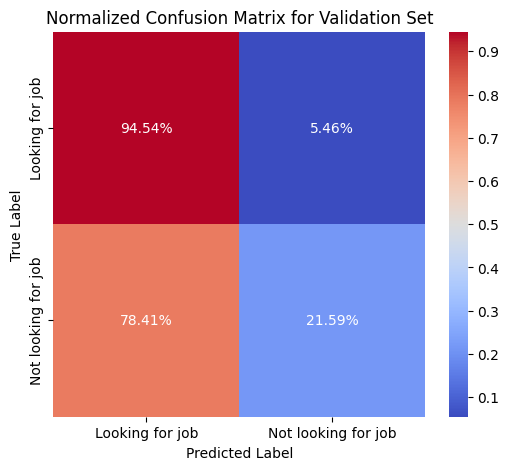

In [76]:
nn_val_cm = confusion_matrix(y_test, y_pred, normalize= "true")
print_ConfusionMatrix(nn_val_cm, "Normalized Confusion Matrix for Validation Set", normalized= True)

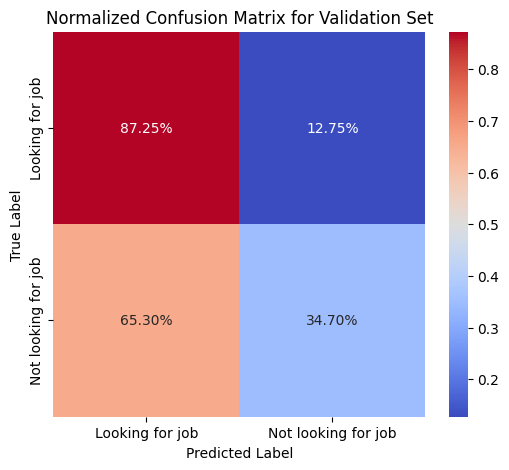

In [77]:
nn_val_cm2 = confusion_matrix(y_test, y_pred2, normalize= "true")
print_ConfusionMatrix(nn_val_cm2, "Normalized Confusion Matrix for Validation Set", normalized= True)

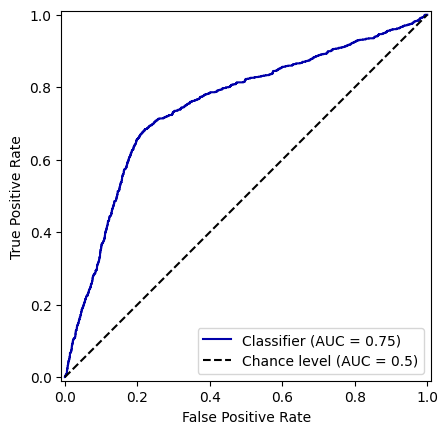

In [67]:
display = RocCurveDisplay.from_predictions(
    y_test,
    nn_val_preds,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

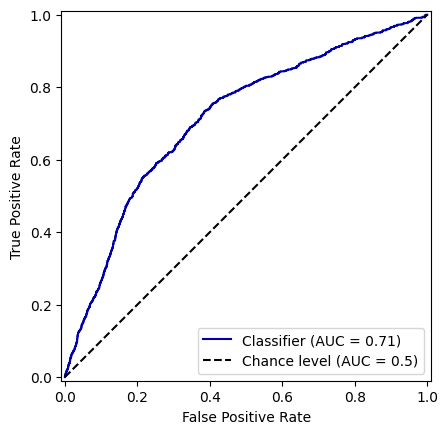

In [78]:
display = RocCurveDisplay.from_predictions(
    y_test,
    nn_val_preds2,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)